In [10]:
import os
import numpy as np
import random
from scipy.io import loadmat
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# 指定文件夹路径
# download_save_path = 'E:/Dataset/wind_shear/Data_Download'
exception_save_path = '../Dataset/Exception_Data'

# 获取文件夹下的所有文件名称
# download_folder_names = [item for item in os.listdir(download_save_path) if os.path.isdir(os.path.join(download_save_path, item))]
exception_folder_names = [item for item in os.listdir(exception_save_path) if os.path.isdir(os.path.join(exception_save_path, item))]
instruction_folder_names = ["@Instructions"]

# 生成所有文件夹路径
# download_folder_paths = [os.path.join(download_save_path, item) for item in download_folder_names]
exception_folder_paths = [os.path.join(exception_save_path, item) for item in exception_folder_names]

# 指定工作文件夹
work_folder_path = exception_folder_paths[3]

# 指定工作mat名称
work_mat_name = os.listdir(work_folder_path)[8]
''' 用[3][2]做train, [3][8]做test
'[0][4]': 652200104170943.mat, 
'[1][0]': 652200108141328.mat, '[1][2]': 652200109050955.mat, '[1][3]': 652200109121214.mat, 
'[3][0]':652200204060950.mat, '[3][2]':652200204251941.mat, '[3][3]':652200205021804.mat, '[3][8]':652200206071302.mat
'''

def dataConstruct(work_folder_path, work_mat_name):
    # 提取WS, WD, TAS并进行重采样
    variable_list = ["WS", "WD", "TAS"]

    work_mat = loadmat(os.path.join(work_folder_path, work_mat_name))

    # 初始化采样数据list
    sampling_data_list = []
    wshr_data = work_mat["WSHR"][0][0][0]
    for var_name in variable_list:
        var_data, var_rate = work_mat[var_name][0][0][0], work_mat[var_name][0][0][1][0][0]
        # 对每个变量按照rate进行下采样或过采样，对长为n+1的数据，抓取前n个全变量为输入，后n个有缺变量为输出
        if var_rate == 1:
            sampling_data = var_data
        else: # 进行重采样
            sampling_data = [var_data[i] for i in np.linspace(0, len(var_data)- 1, len(wshr_data), dtype=int)]
        # 将采样数据进行min_max归一化
        if (np.max(sampling_data) - np.min(sampling_data)) > 1e-5:
            sampling_data = (sampling_data - np.min(sampling_data)) / (np.max(sampling_data) - np.min(sampling_data))
        else:
            sampling_data = sampling_data
        # print(np.max(sampling_data), np.min(sampling_data))
        sampling_data_list.append(sampling_data)

    # 生成解释变量X和分类变量Y
    X = np.squeeze(np.array(sampling_data_list)).T
    Y = np.array(wshr_data).reshape(-1,1)
    wshr_class_idx = [np.where(Y == 0)[0], np.where(Y == 1)[0]]
    # print(X.shape, Y.shape)
    print(wshr_class_idx[0])

    # 绘制X的时间变化
    plt.figure()
    plt.plot(range(len(wshr_data)), X[:, 0], label='Wind Speed')
    plt.plot(range(len(wshr_data)), X[:, 1], label='Wind Direction')
    plt.plot(range(len(wshr_data)), X[:, 2], label='True Air Speed')
    plt.plot(range(len(wshr_data)), Y, c='red', label='Wind Shear Warning')
    plt.xlabel('time(s)')
    plt.ylabel('WS/WD/TAS & WSHR')
    plt.title('Normalized WS/WD/TAS and WSHR')
    plt.legend()
    plt.show()

    # 绘制X的三维散点图
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[wshr_class_idx[1], 0], X[wshr_class_idx[1], 1], X[wshr_class_idx[1], 2], c='green', s = min(len(wshr_class_idx[1]), 50), label='WSHR = 1')
    ax.scatter(X[wshr_class_idx[0], 0], X[wshr_class_idx[0], 1], X[wshr_class_idx[0], 2], c='red', s = len(wshr_class_idx[0])*10, label='WSHR = 0')
    ax.set_xlabel(variable_list[0])
    ax.set_ylabel(variable_list[1])
    ax.set_zlabel(variable_list[2])
    ax.legend()
    plt.tight_layout()
    plt.show()

    return X, Y


[938 939 940 941 942 943]


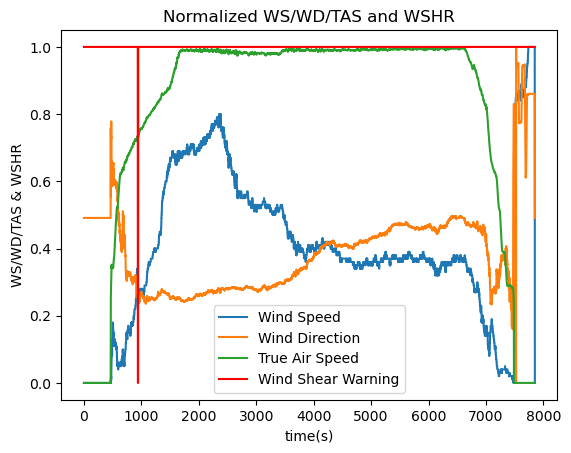

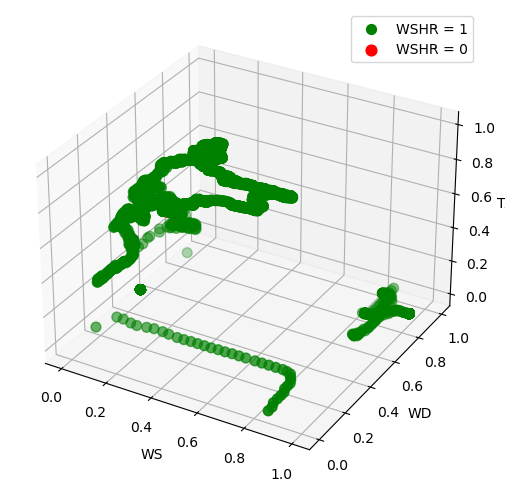

[2289 2290 2291 2292 2293 2294 2295]


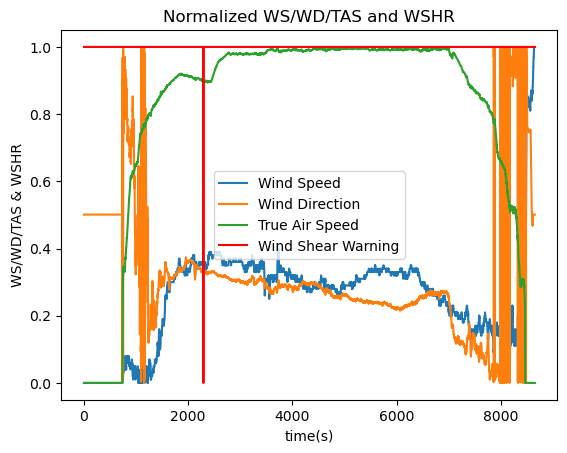

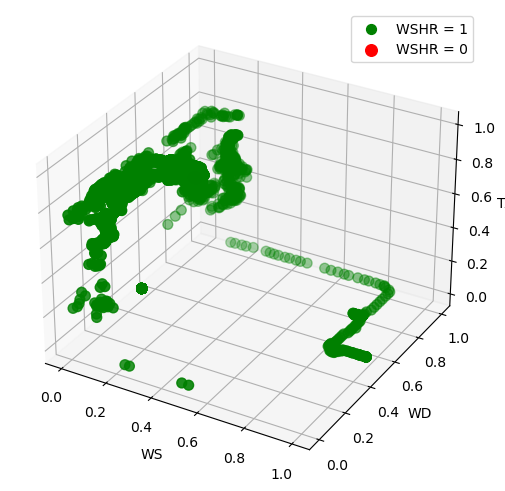

d:\Coding\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0] 1
[0] 1
[0] 1
[0] 1
[0] 1
[0] 1
[0] 1
Accuracy: 99.88%


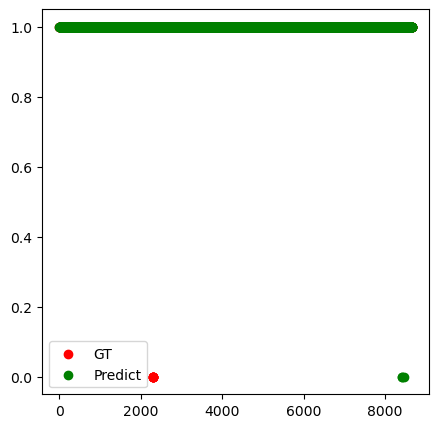

In [12]:
# SVM 二分类
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# 创建支持向量机模型并进行训练
''' kernel & C : accuracy 在[3][2]上的分类效果：
rbf & 7e4: 99.94% # 50%异常识别率
rbf & 1e5: 99.96% # 100% 异常识别率
rbf & 1e6: 99.97%
poly & 7e4: 99.97% # 分类效果最好
sigmoid & 1e2: 99.91% 没有分类效果
'''

''' kernel & C : accuracy 在[3][8]上的分类效果：
rbf & 1e10: 99.92% # 没有分类效果
poly & 1e10: 99.91% # 没有分类效果
sigmoid & 1e2: 99.05% 没有分类效果
'''

# 构建训练和测试数据集
train_X, train_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[2])
test_X, test_Y = dataConstruct(exception_folder_paths[3], os.listdir(exception_folder_paths[3])[8])

# model = SVC(C=1e10, kernel='rbf')  # 选择高斯核函数
model = SVC(C=7e4, kernel='poly')  # 选择三次多项式核函数
# model = SVC(C=1e2, kernel='sigmoid') # 选择sigmoid核函数
model.fit(train_X, train_Y)

# 在测试集上进行预测
Y_pred = model.predict(test_X)

for i in [2289, 2290, 2291, 2292, 2293, 2294, 2295]:
    print(test_Y[i], Y_pred[i])

# 计算准确率
accuracy = accuracy_score(test_Y, Y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# 绘制真实-预测散点图
plt.figure(figsize=(5, 5))
plt.scatter(range(len(test_Y)), test_Y, c='red', label='GT')
plt.scatter(range(len(Y_pred)), Y_pred, c='green', label='Predict')
plt.legend()
plt.show()
